# **Importação das Bibliotecas Necessárias**

In [ ]:
import os
from typing import Tuple, List
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# **Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Configuração de Parametros**

In [ ]:
class Config:
    images_dir = '/content/drive/MyDrive/Modelos/dataset/images'
    masks_dir = '/content/drive/MyDrive/Modelos/dataset/masks'
    img_height = 512
    img_width = 512
    batch_size = 8
    validation_split = 0.2
    epochs = 30

config = Config()

# **Carragamneto e Pré-processamento de Dados**

In [ ]:
def get_image_and_mask_files(images_dir: str, masks_dir: str) -> Tuple[List[str], List[str]]:
    """
    Get sorted lists of image and mask files.
    """
    image_files = sorted(os.listdir(images_dir))
    mask_files = sorted(os.listdir(masks_dir))
    assert len(image_files) == len(mask_files)
    return image_files, mask_files

In [ ]:
def load_and_preprocess_image(img_path: str, mask_path: str, target_size: Tuple[int, int]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Load and preprocess an image and its corresponding mask.
    """
    image = load_img(img_path, target_size=target_size)
    image = img_to_array(image) / 255.0  # Normalize to [0, 1]

    mask = load_img(mask_path, target_size=target_size, color_mode="grayscale")
    mask = img_to_array(mask) / 255.0  # Normalize to [0, 1]
    mask = np.round(mask)  # Ensure mask is binary (0 or 1)

    return image, mask

# **Criação de Conjunto de Dados**

In [ ]:
def create_datasets(image_files: List[str], mask_files: List[str], config: Config) -> Tuple[tf.data.Dataset, tf.data.Dataset]:
    """
    Create TensorFlow datasets for training and validation.
    """
    images_and_masks = [load_and_preprocess_image(os.path.join(config.images_dir, img), os.path.join(config.masks_dir, msk), (config.img_height, config.img_width)) for img, msk in zip(image_files, mask_files)]

    images, masks = zip(*images_and_masks)
    images = np.array(images)
    masks = np.array(masks)

    train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=config.validation_split, random_state=42)

    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks)).batch(config.batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks)).batch(config.batch_size)

    return train_dataset, val_dataset

# **Contrução do Modelo**

In [ ]:
def build_fcn(input_shape: Tuple[int, int, int]) -> tf.keras.Model:
    """
    Build the Fully Convolutional Network (FCN) model.
    """
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

    model = models.Model(inputs, outputs)
    return model

# **Treino e Avaliação**

In [ ]:
#Get image and mask file lists
image_files, mask_files = get_image_and_mask_files(config.images_dir, config.masks_dir)

# Create datasets
train_dataset, val_dataset = create_datasets(image_files, mask_files, config)

# Build and compile the FCN model
fcn_model = build_fcn((config.img_height, config.img_width, 3))
fcn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_metric])

# Train the FCN model
fcn_history = fcn_model.fit(train_dataset, epochs=config.epochs, validation_data=val_dataset)

Epoch 1/30
20/20 [==============================] - 20s 281ms/step - loss: 0.5945 - accuracy: 0.7323 - iou_metric: 0.1915 - val_loss: 0.2843 - val_accuracy: 0.8983 - val_iou_metric: 0.7028
Epoch 2/30
20/20 [==============================] - 6s 281ms/step - loss: 0.3321 - accuracy: 0.8665 - iou_metric: 0.6402 - val_loss: 0.2227 - val_accuracy: 0.9124 - val_iou_metric: 0.7566
Epoch 3/30
20/20 [==============================] - 5s 272ms/step - loss: 0.2163 - accuracy: 0.9118 - iou_metric: 0.7377 - val_loss: 0.1714 - val_accuracy: 0.9280 - val_iou_metric: 0.7994
Epoch 4/30
20/20 [==============================] - 5s 271ms/step - loss: 0.1821 - accuracy: 0.9252 - iou_metric: 0.7828 - val_loss: 0.1564 - val_accuracy: 0.9340 - val_iou_metric: 0.8117
Epoch 5/30
20/20 [==============================] - 5s 271ms/step - loss: 0.1668 - accuracy: 0.9338 - iou_metric: 0.8041 - val_loss: 0.1385 - val_accuracy: 0.9418 - val_iou_metric: 0.8306
Epoch 6/30
20/20 [==============================] - 6s 274m

5/5 [==============================] - 1s 96ms/step - loss: 0.0795 - accuracy: 0.9674 - iou_metric: 0.8984
FCN Model - Loss: 0.07945308089256287 Accuracy: 0.8983756899833679


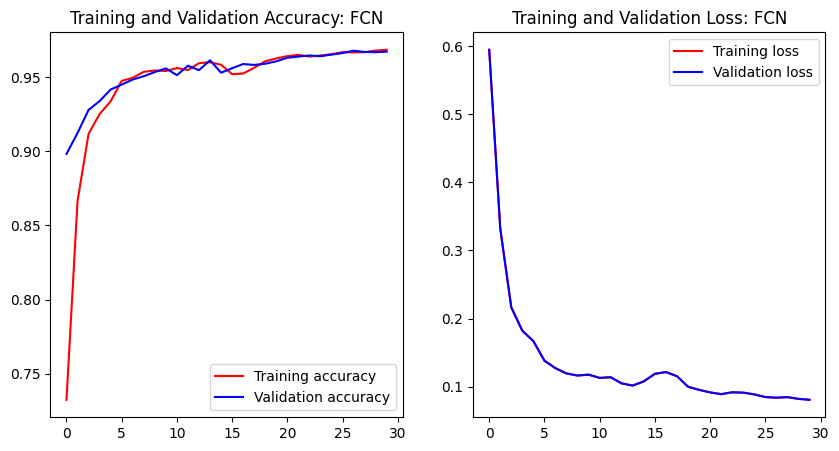

In [ ]:
# Evaluate the FCN model
fcn_loss, fcn_accuracy, fcn_accuracy = fcn_model.evaluate(val_dataset)
print("FCN Model - Loss:", fcn_loss, "Accuracy:", fcn_accuracy)

# **Visualização**

In [ ]:
def plot_history(history: tf.keras.callbacks.History, title: str) -> None:
    """
    Plot training and validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    epochs = range(len(acc))

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title(f'Training and Validation Accuracy: {title}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, loss, 'b', label='Validation loss')
    plt.title(f'Training and Validation Loss: {title}')
    plt.legend()

    plt.show()

In [ ]:
# Plot training history
plot_history(fcn_history, 'FCN')

# **Teste e Previsão**

In [ ]:
def calculate_iou(pred_mask: np.ndarray, true_mask: np.ndarray) -> float:
    """
    Calculate the Intersection over Union (IoU) score between the predicted mask and the true mask.
    """
    pred_mask = np.round(pred_mask)
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()
    iou = intersection / union if union != 0 else 0.0
    return iou

def iou_metric(y_true, y_pred):
    y_pred = K.round(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    iou = (intersection + K.epsilon()) / (union + K.epsilon())
    return iou

In [ ]:
def predict_and_display_mask(model: tf.keras.Model, img_path: str, mask_path: str, config: Config) -> None:
    """
    Load an image, preprocess it, and display the image along with the predicted and ground truth masks.
    Calculate and display the IoU score.
    """
    # Load and preprocess the image
    image = load_img(img_path, target_size=(config.img_height, config.img_width))
    input_arr = img_to_array(image) / 255.0  # Normalize to [0, 1]
    input_arr = np.expand_dims(input_arr, axis=0)  # Create a batch dimension

    # Predict the mask
    predicted_mask = model.predict(input_arr)[0].squeeze()

    # Load and preprocess the ground truth mask
    ground_truth_mask = load_img(mask_path, target_size=(config.img_height, config.img_width), color_mode="grayscale")
    ground_truth_mask = img_to_array(ground_truth_mask) / 255.0  # Normalize to [0, 1]
    ground_truth_mask = ground_truth_mask.squeeze(axis=-1)  # Remove the channel dimension if present

    # Calculate IoU score
    iou_score = calculate_iou(predicted_mask, ground_truth_mask)
    print(f"IoU score: {iou_score:.4f}")

    # Plot the original image, predicted mask, and ground truth mask
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.title('Ground Truth Mask')

    plt.show()

1/1 [==============================] - 0s 20ms/step
IoU score: 0.8900


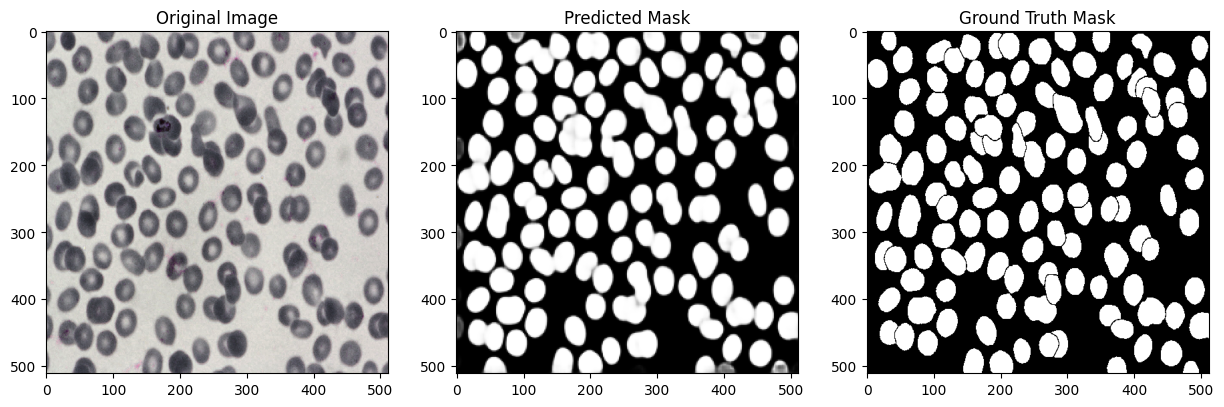

In [ ]:
# Test the model on an external image
test_image_path = '/content/drive/MyDrive/Modelos/dataset/test_images/daea4860-a296-4f6d-acef-996ab0882676.png'
test_mask_path = '/content/drive/MyDrive/Modelos/dataset/test_masks/daea4860-a296-4f6d-acef-996ab0882676.png'
predict_and_display_mask(fcn_model, test_image_path, test_mask_path, config)

# **Guardar o Modelo Treinado**

In [ ]:
def save_model(model: tf.keras.Model, save_dir: str) -> None:
    """
    Save the trained model to the specified directory.
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    model.save(save_dir)
    print("Model saved successfully.")